# 65 Cross validation - scikit-learn

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [15]:
import torch
import torch.nn as nn

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import datasets

In [69]:
# import iris dataset
iris_dataset = datasets.load_iris()
data = torch.tensor(iris_dataset['data']).float()
labels = torch.tensor(iris_dataset['target'], dtype=torch.long)

torch.int64

## A brief adide on using train_test_split

In [70]:
# np.tile(A, reps), repeat A by number of reps (row_times, column_times)
fakedata = np.tile(np.array([1, 2, 3, 4]), (10, 1)) + np.tile(10 * np.array(range(1, 11)), (4, 1)).T # add together element-wise
fakelables = (np.arange(10)>4).astype(int)

In [71]:
train_data, test_data, train_labels, test_labels = train_test_split(fakedata, fakelables, test_size=0.2)

In [72]:
# use scikit-learn to split train test data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)

In [111]:
train_labels

tensor([1, 0, 0, 2, 2, 1, 2, 1, 0, 2, 2, 2, 2, 2, 1, 0, 0, 1, 1, 0, 1, 0, 1, 2,
        0, 2, 1, 0, 2, 0, 0, 2, 1, 0, 1, 0, 2, 2, 2, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        0, 1, 2, 2, 2, 0, 1, 1, 1, 2, 2, 0, 2, 1, 2, 2, 0, 2, 0, 2, 1, 0, 0, 0,
        2, 1, 2, 0, 2, 1, 1, 0, 0, 1, 1, 0, 0, 2, 0, 0, 1, 2, 1, 2, 0, 0, 1, 1,
        2, 2, 0, 2, 1, 2, 0, 2, 1, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 2, 0, 2, 0, 1])

In [73]:
train_data.shape, test_data.shape, train_labels.shape, test_labels.shape

(torch.Size([120, 4]),
 torch.Size([30, 4]),
 torch.Size([120]),
 torch.Size([30]))

## model

In [129]:
# A function that create the ANN model

def createANewModel():
    ANNiris = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
        )

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.01)

    return ANNiris,lossfun,optimizer

In [147]:
# train the model

# global parameter
numepochs = 200

def tainTheModel(trainProp, ANNModel, lossfunc, optimizer, data, labels):

    # initialize losses
    losses = torch.zeros(numepochs)

    trainAcc = []
    testAcc = []

    # split once for all epochs, to avoid overfitting. If split in the epochs loop, 
    # some data in the train set in one epoch will be in test set in another epoch
    X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size=trainProp)

    # loop over epochs
    for epochi in range(numepochs):
        # separate train test data
        # Note1: unique split for each epoch!
        # Note2: Here we specify the training size, not the testing size
        

        # forward pass
        yHat = ANNModel(X_train)
        loss = lossfunc(yHat, y_train)

        # back prop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # training accuracy
        trainPred_labels = torch.argmax(yHat, axis = 1)
        # print(trainPred_labels)
        fc = (trainPred_labels == y_train).float()
        # print(fc)
        acc = 100 * torch.mean(fc).item()
        trainAcc.append(acc)

        # test accuracy
        yHat_test = ANNModel(X_test)
        testPred_labels = torch.argmax(yHat_test, axis = 1)
        # print(f'test_pred size = {testPred_labels.shape}'), print(f'test actual = {y_test.shape}')
        fc_test = (testPred_labels == y_test).float()
        acc_test = 100 * torch.mean(fc_test).item()
        testAcc.append(acc_test)

    # function output
    return trainAcc, testAcc



In [148]:
ANNModel, lossfunc, optimizer = createANewModel()

In [149]:
trainProp = 0.8
trainAcc, testAcc = tainTheModel(trainProp, ANNModel, lossfunc, optimizer, data, labels)

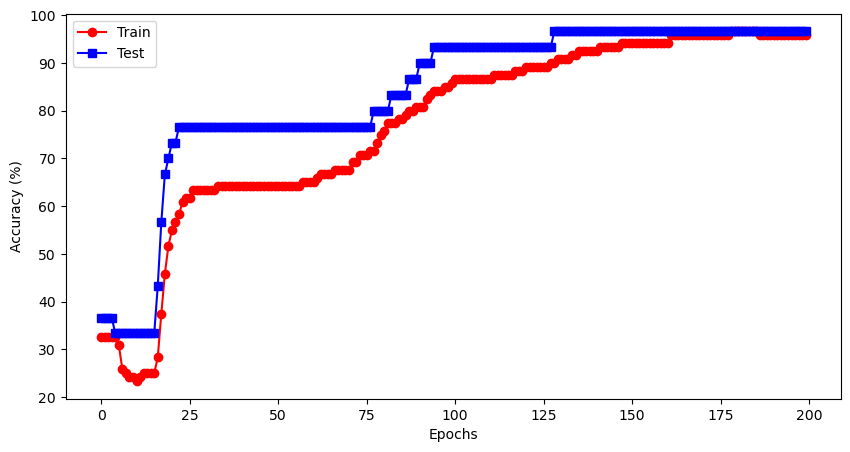

In [150]:
# plot the result
fig = plt.figure(figsize=(10, 5))
plt.plot(trainAcc, 'ro-')
plt.plot(testAcc, 'bs-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train', 'Test'])

plt.show()

In [151]:
# experiments
trainSetSizes = np.linspace(0.2, 0.95, 10)

allTrainAcc = np.zeros((len(trainSetSizes), numepochs))
allTestAcc = np.zeros((len(trainSetSizes), numepochs))

for i in range(len(trainSetSizes)):
    # create a model
    ANNModel, lossfunc, optimizer = createANewModel()

    # train model
    trainAcc, testAcc = tainTheModel(trainSetSizes[i], ANNModel, lossfunc, optimizer, data, labels)

    allTrainAcc[i, :] = trainAcc
    allTestAcc[i, :] = testAcc

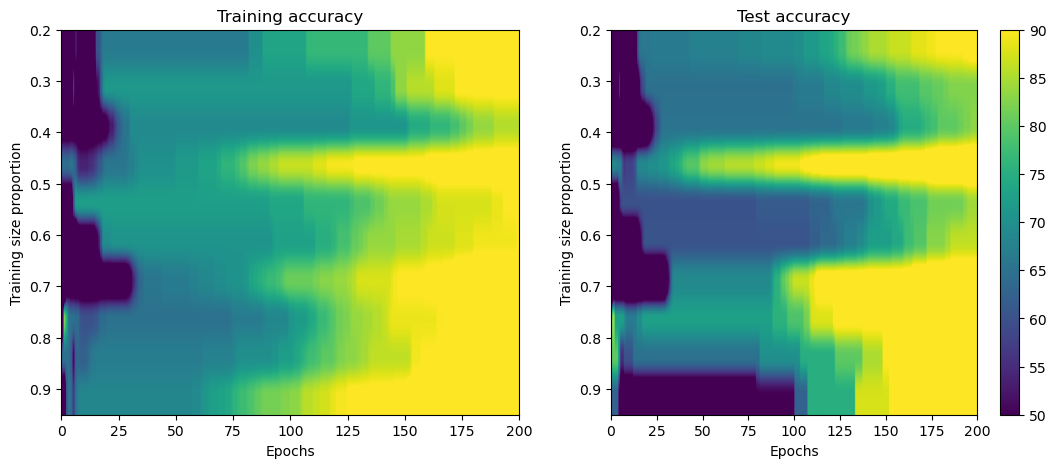

In [161]:
fig, ax = plt.subplots(1, 2, figsize = (13, 5))
ax[0].imshow(allTrainAcc, aspect = 'auto', vmin = 50, vmax = 90,extent = [0, numepochs, trainSetSizes[-1], trainSetSizes[0]])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training size proportion')
ax[0].set_title('Training accuracy')

p = ax[1].imshow(allTestAcc, aspect = 'auto', vmin = 50, vmax = 90,extent = [0, numepochs, trainSetSizes[-1], trainSetSizes[0]])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training size proportion')
ax[1].set_title('Test accuracy')

fig.colorbar(p, ax = ax[1])

plt.show()



In [160]:
[0, numepochs, trainSetSizes[-1], trainSetSizes[0]]

[0, 200, 0.95, 0.2]

# 66 Cross-validation - DataLoader

In [27]:
# import libraries
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader, TensorDataset

In [5]:
# import iris data
from sklearn import datasets
iris = datasets.load_iris()
data = torch.tensor(iris['data']).float()
labels = torch.tensor(iris['target'], dtype=torch.long)

## A brief aside on using Dataloader

In [8]:
fakedata = np.tile(np.array([1, 2 ,3 ,4]), (10, 1)) + np.tile(10 * np.arange(1, 11), (4, 1)).T
fakelables = np.arange(10) > 4

In [10]:
fakedataLdr = DataLoader(fakedata, shuffle=True)

In [14]:
print(fakedataLdr)
print(fakedataLdr.batch_size)

1


In [16]:
for i in fakedataLdr:
    print(i, i.shape)

tensor([[81, 82, 83, 84]], dtype=torch.int32) torch.Size([1, 4])
tensor([[101, 102, 103, 104]], dtype=torch.int32) torch.Size([1, 4])
tensor([[91, 92, 93, 94]], dtype=torch.int32) torch.Size([1, 4])
tensor([[41, 42, 43, 44]], dtype=torch.int32) torch.Size([1, 4])
tensor([[71, 72, 73, 74]], dtype=torch.int32) torch.Size([1, 4])
tensor([[51, 52, 53, 54]], dtype=torch.int32) torch.Size([1, 4])
tensor([[21, 22, 23, 24]], dtype=torch.int32) torch.Size([1, 4])
tensor([[61, 62, 63, 64]], dtype=torch.int32) torch.Size([1, 4])
tensor([[31, 32, 33, 34]], dtype=torch.int32) torch.Size([1, 4])
tensor([[11, 12, 13, 14]], dtype=torch.int32) torch.Size([1, 4])


In [28]:
# We need to create a Dataset that contains the data and the labels
# it forms an iterator, each item of the iterator is 2-element tuple, 
# first element is a tensor with one row of the X data, another el is a tensor with one y
fakeDataset = TensorDataset(
    torch.Tensor(fakedata), 
    torch.Tensor(fakelables)
)

In [26]:
for i in fakeDataset:
    print(i)
    

(tensor([11., 12., 13., 14.]), tensor(0.))
(tensor([21., 22., 23., 24.]), tensor(0.))
(tensor([31., 32., 33., 34.]), tensor(0.))
(tensor([41., 42., 43., 44.]), tensor(0.))
(tensor([51., 52., 53., 54.]), tensor(0.))
(tensor([61., 62., 63., 64.]), tensor(1.))
(tensor([71., 72., 73., 74.]), tensor(1.))
(tensor([81., 82., 83., 84.]), tensor(1.))
(tensor([91., 92., 93., 94.]), tensor(1.))
(tensor([101., 102., 103., 104.]), tensor(1.))


In [29]:
# create another dataLoader

fakedataLdr = DataLoader(fakeDataset, shuffle=True)

In [31]:
for OneSample in fakedataLdr:
    print(OneSample)

[tensor([[31., 32., 33., 34.]]), tensor([0.])]
[tensor([[71., 72., 73., 74.]]), tensor([1.])]
[tensor([[61., 62., 63., 64.]]), tensor([1.])]
[tensor([[101., 102., 103., 104.]]), tensor([1.])]
[tensor([[41., 42., 43., 44.]]), tensor([0.])]
[tensor([[91., 92., 93., 94.]]), tensor([1.])]
[tensor([[21., 22., 23., 24.]]), tensor([0.])]
[tensor([[81., 82., 83., 84.]]), tensor([1.])]
[tensor([[11., 12., 13., 14.]]), tensor([0.])]
[tensor([[51., 52., 53., 54.]]), tensor([0.])]


In [78]:
# use scikit-learn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(fakedata, fakelables, test_size=0.2)

# convert the splitted data into PyTorch Datasets
train_data = TensorDataset(torch.tensor(train_data), torch.tensor(train_labels))
test_data = TensorDataset(torch.tensor(test_data), torch.tensor(test_labels))

# finally, translate into dataloader objects
# when batch_size is 4, the tensor will be 4X, see the next cell
train_loader = DataLoader(train_data, batch_size=4) # batch_size default is 1, namely each row will be a tensor
test_loader = DataLoader(test_data)

In [81]:
for i in train_data:
    print(i)

(tensor([71, 72, 73, 74], dtype=torch.int32), tensor(True))
(tensor([91, 92, 93, 94], dtype=torch.int32), tensor(True))
(tensor([21, 22, 23, 24], dtype=torch.int32), tensor(False))
(tensor([11, 12, 13, 14], dtype=torch.int32), tensor(False))
(tensor([61, 62, 63, 64], dtype=torch.int32), tensor(True))
(tensor([31, 32, 33, 34], dtype=torch.int32), tensor(False))
(tensor([101, 102, 103, 104], dtype=torch.int32), tensor(True))
(tensor([81, 82, 83, 84], dtype=torch.int32), tensor(True))


In [42]:
for i in train_loader:
    print(i)

# split into 2 batches

[tensor([[51, 52, 53, 54],
        [61, 62, 63, 64],
        [11, 12, 13, 14],
        [91, 92, 93, 94]], dtype=torch.int32), tensor([False,  True, False,  True])]
[tensor([[41, 42, 43, 44],
        [21, 22, 23, 24],
        [81, 82, 83, 84],
        [31, 32, 33, 34]], dtype=torch.int32), tensor([False, False,  True, False])]


In [44]:
for i in test_loader:
    print(i)

# batch_size = 1 (default), meaning that each row is a tensor

[tensor([[71, 72, 73, 74]], dtype=torch.int32), tensor([True])]
[tensor([[101, 102, 103, 104]], dtype=torch.int32), tensor([True])]


## Real data

In [113]:
# using scikit-learn to split data

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, train_size= 0.8)

# then convert into PyTorch datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# translate into DataLoader objects
train_loader = DataLoader(train_data, shuffle=True, batch_size=12)
# TensorDataset instance.tensors return a 2-element tuple, first el is a tensor with training data, second is the label
# the batch size is the same as the number of the rows in the test data
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])


In [87]:
# check the sizes of the data batches
for X, y in train_loader:
    print(X.shape, y.shape)


torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])


In [120]:
# function to create ANN model
def createANNModel():
    ANNModel = nn.Sequential(
        nn.Linear(4, 64), # input layer
        nn.ReLU(), # activation unit
        nn.Linear(64, 64), # hidden layer
        nn.ReLU(), # activation unit
        nn.Linear(64, 3), # output layer
    )

    lossfunc = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(ANNModel.parameters(), lr = 0.01)

    return ANNModel, lossfunc, optimizer

In [121]:
# train function

# global parameter
numepochs = 500

# define a helper func
def calc_accuracy(yHat, y):
    fc_label = torch.argmax(yHat, axis = 1)
    fc = (fc_label == y).float()
    return 100 * torch.mean(fc).item()


def trainTheModel(train_loader, test_loader, ANNModel, lossfunc, optimizer):

    # initialize losses
    losses = torch.zeros(numepochs)

    trainAcc = []
    testAcc = []

    # loop over epochs
    for epochi in range(numepochs):
        
        # loop over train data batches
        batchAcc = []
        for X, y in train_loader:
            # forward pass and loss
            yHat = ANNModel(X)
            loss = lossfunc(yHat, y)

            # back propogation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # training accuracy
            batchAcc.append(calc_accuracy(yHat, y))

        # end of batch loop
            
        # train accuracy
        trainAcc.append(np.mean(batchAcc))

        # test accuracy
        X_test, y_test = next(iter(test_loader)) # extract X, y from test dataloader. Only one batch, this will work to get all test data
        yHat_test = ANNModel(X_test)
        testAcc.append(calc_accuracy(yHat_test, y_test))

    # function output
    return trainAcc, testAcc

## Modelling

In [122]:
# create a model
ANNModel, lossfunc, optimizer = createANNModel()

# train the model
trainAcc, testAcc = trainTheModel(train_loader, test_loader, ANNModel, lossfunc, optimizer)

In [123]:
trainAcc, testAcc

([29.166666939854622,
  34.166666716337204,
  50.83333306014538,
  60.83333283662796,
  62.49999910593033,
  73.33333313465118,
  73.33333373069763,
  69.16666686534882,
  68.33333373069763,
  75.00000059604645,
  83.33333253860474,
  70.83333253860474,
  86.66666746139526,
  73.33333313465118,
  85.83333313465118,
  77.50000029802322,
  78.33333313465118,
  84.16666626930237,
  89.16666686534882,
  86.66666686534882,
  85.00000059604645,
  91.66666686534882,
  85.0,
  93.33333432674408,
  88.33333313465118,
  89.16666626930237,
  90.0,
  90.83333373069763,
  92.50000059604645,
  92.5,
  93.33333373069763,
  93.33333373069763,
  93.33333313465118,
  91.66666686534882,
  95.0,
  95.00000059604645,
  93.33333432674408,
  94.16666686534882,
  95.83333432674408,
  95.83333373069763,
  92.50000059604645,
  87.5,
  93.33333432674408,
  94.16666746139526,
  95.0,
  94.16666686534882,
  96.66666686534882,
  92.5000011920929,
  95.0000011920929,
  95.0000011920929,
  94.16666686534882,
  94.166

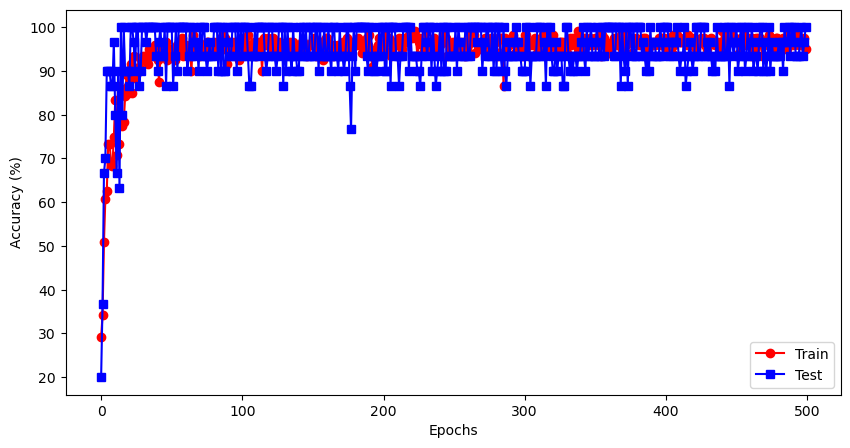

In [125]:
# plot the result
fig = plt.figure(figsize=(10, 5))
plt.plot(trainAcc, 'ro-')
plt.plot(testAcc, 'bs-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train', 'Test'])

plt.show()

# it trains every fast to reach high accuracy. So batch training with DataLoader improve model performance